In [ ]:
# Importing required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import gc
import matplotlib.dates as mdates
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from vit_solar.efficient_forecast import ViT
from linformer import Linformer

from utils import *

%matplotlib inline

In [ ]:
# Checking pytorch version
print("pytorch version:", torch.__version__)

# Checking available GPU and CPU
print("Available gpus:", torch.cuda.device_count())
print("Available cpus:", os.cpu_count())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used: ", device)

pytorch version: 2.0.0+cu118
Available gpus: 1
Available cpus: 16
Device used:  cuda


In [ ]:
cwd = os.getcwd()
print(cwd)
print(os.path.dirname(cwd))

# Defining data location
cwd = os.getcwd()
data_folder = os.path.join(cwd,"SolarForecastDataset")
data_path = os.path.join(data_folder, "forecast_dataset.hdf5")
print("data_folder:", data_folder)
print("data_path:", data_path)

C:\Users\sashah8\Neural_nets\vit_pv_forecast
C:\Users\sashah8\Neural_nets
data_folder: C:\Users\sashah8\Neural_nets\vit_pv_forecast\SolarForecastDataset
data_path: C:\Users\sashah8\Neural_nets\vit_pv_forecast\SolarForecastDataset\forecast_dataset.hdf5


In [ ]:
# Directory for saving models
model_name = 'ViT_forecast_2017_2019_data'
output_folder = os.path.join(cwd,"model_output", model_name)

if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

In [ ]:
# Creating H5PY file handler
forecast_dataset = h5py.File(data_path, 'r')

# Model structure utility
def get_all(name):
    if name is not None:
        print(forecast_dataset[name])
    
forecast_dataset.visit(get_all)

<HDF5 group "/test" (2 members)>
<HDF5 dataset "images_log": shape (14003, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (14003,), type "<f8">
<HDF5 group "/trainval" (2 members)>
<HDF5 dataset "images_log": shape (349372, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (349372,), type "<f8">


In [ ]:
#### EASY METHOD
overlap = 8
n_hist_stepbacks = 16
images_trainval = forecast_dataset['trainval']['images_log'][:-n_hist_stepbacks - 12]
pvlog_trainval = forecast_dataset['trainval']['pv_log'][:-n_hist_stepbacks - 12]
pvpred_trainval_sampled = forecast_dataset['trainval']['pv_log'][31:-12][::overlap]

print(images_trainval.shape[0])
n_images = images_trainval.shape[0]

# Defining sample start points
idx_start_pts = list(range(0, n_images - n_hist_stepbacks + 1, overlap))
print(idx_start_pts[:5])

# New indices list for creating overlaps
idx_overlap_indices = [list(range(i, i + n_hist_stepbacks)) for i in idx_start_pts]
print("Number of overlapped samples: ", len(idx_overlap_indices))

# Creating the newly sampled image dataset
images_trainval_sampled = images_trainval[()][idx_overlap_indices].reshape(-1, 16, 64, 64, 3)
pvlog_trainval_sampled = pvlog_trainval[()][idx_overlap_indices].reshape(-1, 16)
print("Shape of new trainval images dataset: ", images_trainval_sampled.shape)
print("Shape of new trainval PV log dataset: ", pvlog_trainval_sampled.shape)

# Sanity check
check_idx = 5
(images_trainval_sampled[0][check_idx + overlap] == images_trainval_sampled[1][check_idx]).all()
print(pvpred_trainval_sampled.shape)

349344
[0, 8, 16, 24, 32]
Number of overlapped samples:  43667
Shape of new trainval images dataset:  (43667, 16, 64, 64, 3)
Shape of new trainval PV log dataset:  (43667, 16)
(43667,)


In [ ]:
print(pvpred_trainval_sampled[0])
print(forecast_dataset['trainval']['pv_log'][:32])

1.569898911
[0.05569101 0.08876321 0.10917138 0.12320565 0.15974765 0.18755351
 0.24671187 0.30560185 0.37730614 0.35950663 0.34513365 0.35472508
 0.39066438 0.45460775 0.50538221 0.54651637 0.60125552 0.65652281
 0.70025651 0.76101853 0.81386366 0.86282463 0.91714126 0.98967718
 1.0554108  1.12238867 1.19649125 1.27672122 1.34783787 1.43136384
 1.49355362 1.56989891]


In [ ]:
print(pvpred_trainval_sampled[-1])
print(forecast_dataset['trainval']['pv_log'][-28:-12])

1.2062122763333334
[3.1713828  3.02142261 2.87455897 2.73998264 2.62269425 2.49765905
 2.36577764 2.23496425 2.09868844 1.96741663 1.83356325 1.68159623
 1.53808169 1.412056   1.30611652 1.20621228]


In [ ]:
# Fetching the input dimension for constructing the model
img_side_len = images_trainval_sampled.shape[2]
num_lag_term = images_trainval_sampled.shape[1]
num_channel = images_trainval_sampled.shape[4]*images_trainval_sampled.shape[1]

image_input_dim = [img_side_len, img_side_len, num_channel]
print("Input image dimension:", image_input_dim)

# Loading train-validation time stamps
times_trainval = np.load(os.path.join(data_folder,"times_trainval.npy"),allow_pickle=True)
times_trainval = times_trainval[()][31:-12][::overlap]
print("times_trainval.shape:", times_trainval.shape)

Input image dimension: [64, 64, 48]
times_trainval.shape: (43667,)


In [ ]:
transforms = transforms.Compose([transforms.ToTensor()])

def process_image(image_data):

    ## reshape the image tensor from [None,16,64,64,3] to [None,64,64,48]
    image_data = image_data.reshape(image_data.shape[0]*image_data.shape[3],
                                    image_data.shape[1], image_data.shape[2])

    return image_data

In [ ]:
class dataset(torch.utils.data.Dataset):

    def __init__(self,image,pv,pv_pred,transform=None):
        self.image = image
        self.pv = pv
        self.pv_pred = pv_pred
        self.transform = transform

    #dataset length
    def __len__(self):
        self.filelength = len(self.image)
        return self.filelength

    #load an one of images
    def __getitem__(self,idx):
        img_idx = self.image[idx]
        img_idx = process_image(img_idx)
        img_transformed = self.transform(img_idx)
        img_transformed = torch.permute(img_transformed, (1,0,2))
        img_transformed = img_transformed.to(torch.float32)

        pv_idx = self.pv[idx]
        pv_info = torch.as_tensor(pv_idx, dtype=torch.float32)

        pv_pred_idx = self.pv_pred[idx]
        pv_pred_info = torch.as_tensor(pv_pred_idx, dtype=torch.float32)

        return img_transformed, pv_info, pv_pred_info

## Model Architecture

In [ ]:
# define training time parameters
num_epochs = 300
num_fold = 10 # 10-fold cross-validation
batch_size = 512
learning_rate = 1e-06

In [ ]:
patch_size_tuned = 32
patch_seq_tuned = (img_side_len // patch_size_tuned) ** 2

In [ ]:
efficient_transformer = Linformer(
    dim=1240,
    seq_len=patch_seq_tuned+1,
    depth=4,
    heads=4,
    k=64
)

model = ViT(
    dim=1240,
    hist_dim=16,
    image_size=img_side_len,
    patch_size=patch_size_tuned,
    num_classes=1,
    channels=48,
    transformer=efficient_transformer,
    pool='mean',
).to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
summary(model,[(48,64,64), (1,1,16)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 4, 49152]               0
         LayerNorm-2             [-1, 4, 49152]          98,304
            Linear-3              [-1, 4, 1240]      60,949,720
         LayerNorm-4              [-1, 4, 1240]           2,480
         LayerNorm-5              [-1, 5, 1240]           2,480
            Linear-6              [-1, 5, 1240]       1,537,600
            Linear-7              [-1, 5, 1240]       1,537,600
            Linear-8              [-1, 5, 1240]       1,537,600
           Dropout-9             [-1, 4, 5, 64]               0
           Linear-10              [-1, 5, 1240]       1,538,840
LinformerSelfAttention-11              [-1, 5, 1240]               0
          PreNorm-12              [-1, 5, 1240]               0
        LayerNorm-13              [-1, 5, 1240]           2,480
           Linear-14              

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path="best_model.pth", trace_func=print):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Loading Data and Model Training

In [ ]:
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

indices_train, indices_val = cv_split(indices_dayblock_shuffled,9,num_fold) 
data_path = data_path
indices_train = sorted(indices_train)
indices_val = sorted(indices_val)

train_data = dataset(images_trainval_sampled[indices_train],
                     pvlog_trainval_sampled[indices_train],
                     pvpred_trainval_sampled[indices_train],
                     transform=transforms)

val_data = dataset(images_trainval_sampled[indices_val],
                   pvlog_trainval_sampled[indices_val],
                   pvpred_trainval_sampled[indices_val],
                   transform= transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size,
                                           shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

[Epoch     1 of 300] loss: 128.518799 val_loss: 92.076340
Validation loss decreased (inf --> 92.076340).  Saving model ...
[Epoch     2 of 300] loss: 73.097969 val_loss: 58.297695
Validation loss decreased (92.076340 --> 58.297695).  Saving model ...
[Epoch     3 of 300] loss: 45.284996 val_loss: 34.424137
Validation loss decreased (58.297695 --> 34.424137).  Saving model ...
[Epoch     4 of 300] loss: 26.824759 val_loss: 20.053873
Validation loss decreased (34.424137 --> 20.053873).  Saving model ...
[Epoch     5 of 300] loss: 16.431322 val_loss: 12.925316
Validation loss decreased (20.053873 --> 12.925316).  Saving model ...
[Epoch     6 of 300] loss: 11.431694 val_loss: 9.551567
Validation loss decreased (12.925316 --> 9.551567).  Saving model ...
[Epoch     7 of 300] loss: 9.040126 val_loss: 7.913517
Validation loss decreased (9.551567 --> 7.913517).  Saving model ...
[Epoch     8 of 300] loss: 7.825998 val_loss: 6.942685
Validation loss decreased (7.913517 --> 6.942685).  Saving m

<All keys matched successfully>

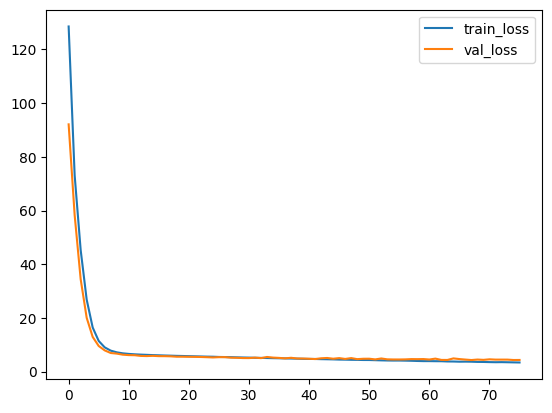

In [ ]:
train_loss_epoch = []
val_loss_epoch = []

save_directory = os.path.join(output_folder,'Model_Checkpoint')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model_path = os.path.join(save_directory,"best_model.pth")
early_stopping = EarlyStopping(patience=8, verbose=True, path=model_path)

for t in range(num_epochs):
  epoch_loss = 0
  model.train()
  for images_log_train, pv_log_train, pv_pred_train in train_loader:
      images_log_train = images_log_train.to(device)
      pv_log_train = pv_log_train.to(device)
      pv_log_train = torch.unsqueeze(pv_log_train, 1)
      pv_pred_train = pv_pred_train.to(device)
      pred_train = model(images_log_train, pv_log_train)
      loss_train = loss_fn(torch.squeeze(pred_train), pv_pred_train)
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()

      epoch_loss += loss_train.detach()/len(train_loader)

  model.eval()
  with torch.no_grad():
      epoch_loss_val = 0
      for images_log_val, pv_log_val, pv_pred_val in val_loader:
          images_log_val = images_log_val.to(device)
          pv_log_val = pv_log_val.to(device)
          pv_log_val = torch.unsqueeze(pv_log_val, 1)
          pv_pred_val = pv_pred_val.to(device)
          pred_val = model(images_log_val, pv_log_val)
          loss_val = loss_fn(torch.squeeze(pred_val), pv_pred_val)

          epoch_loss_val += loss_val.detach()/len(val_loader)
    
      print("[Epoch {t:5d} of {epochs}] loss: {loss:1.6f} val_loss: {val_loss:1.6f}".format(t=t+1,epochs= num_epochs,loss=epoch_loss,val_loss=epoch_loss_val))
      
      train_loss_epoch.append(epoch_loss.item())
      val_loss_epoch.append(epoch_loss_val.item())
      early_stopping(epoch_loss_val, model)
          
      if early_stopping.early_stop:
          print("Early stopping")
          break
      gc.collect()
      
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss_epoch,label='val_loss')
plt.legend()
plt.show

model.load_state_dict(torch.load(model_path))

In [ ]:
best_val_loss_MSE = np.min(val_loss_epoch)
idx = np.argmin(val_loss_epoch)

In [ ]:
best_val_loss_MSE = np.min(val_loss_epoch)
idx = np.argmin(val_loss_epoch)
best_train_loss_MSE = train_loss_epoch[idx]
print('Best Model train loss: {0:.2f}, validation loss: {1:.2f} (RMSE)'.format(np.sqrt(best_train_loss_MSE),
                                                                               np.sqrt(best_val_loss_MSE)))

Best Model train loss: 1.92, validation loss: 2.08 (RMSE)


In [ ]:
del train_loader, val_loader

In [ ]:
gc.collect()

3965

## Model Testing and Evaluation

In [ ]:
save_directory = os.path.join(output_folder,'Model_Checkpoint')
model_path = os.path.join(save_directory,"best_model.pth")
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
#### EASY METHOD
overlap = 4
n_hist_stepbacks = 16
images_log_test = forecast_dataset['test']['images_log'][:-n_hist_stepbacks - 3]
pv_log_test = forecast_dataset['test']['pv_log'][:-n_hist_stepbacks - 3]
pv_pred_test = forecast_dataset['test']['pv_log'][31:-3][::overlap]

print(images_log_test.shape[0])
n_images = images_log_test.shape[0]

# Defining sample start points
idx_start_pts = list(range(0, n_images - n_hist_stepbacks + 1, overlap))
print(idx_start_pts[:5])

# New indices list for creating overlaps
idx_overlap_indices = [list(range(i, i + n_hist_stepbacks)) for i in idx_start_pts]
print("Number of overlapped samples: ", len(idx_overlap_indices))

# Creating the newly sampled image dataset
images_log_test = images_log_test[()][idx_overlap_indices].reshape(-1, 16, 64, 64, 3)
pv_log_test = pv_log_test[()][idx_overlap_indices].reshape(-1, 16)
print("Shape of new trainval images dataset: ", images_log_test.shape)
print("Shape of new trainval PV log dataset: ", pv_log_test.shape)

# Sanity check
check_idx = 5
(images_log_test[0][check_idx + overlap] == images_log_test[1][check_idx]).all()
print(pv_pred_test.shape)
print(pv_pred_test[0])
print(forecast_dataset['test']['pv_log'][:32])

13984
[0, 4, 8, 12, 16]
Number of overlapped samples:  3493
Shape of new trainval images dataset:  (3493, 16, 64, 64, 3)
Shape of new trainval PV log dataset:  (3493, 16)
(3493,)
1.032591428
[0.04631056 0.06190734 0.0738412  0.08070637 0.09189038 0.10936879
 0.12321492 0.13813878 0.15258164 0.16490837 0.17708973 0.19375385
 0.23054306 0.25510894 0.27647492 0.30406981 0.33018259 0.35325804
 0.38149509 0.42219869 0.47344626 0.51155651 0.54018608 0.59355869
 0.64092648 0.69365205 0.74484109 0.7944698  0.85651954 0.91172369
 0.96569812 1.03259143]


In [ ]:
times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
times_test = times_test[()][31:-3][::overlap]
print("times_test.shape:", times_test.shape)

# process image data -> LEFT
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

times_test.shape: (3493,)
images_log_test.shape: (3493, 16, 64, 64, 3)
pv_log_test.shape: (3493, 16)


In [ ]:
test_data = dataset(images_log_test, pv_log_test, pv_pred_test, transform=transforms)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size,num_workers=0)

In [ ]:
print("evaluating performance for the model")
preds_total = []
model.eval()
test_preds = []
avg_loss_test = 0
with torch.no_grad():
  for data_test, pv_test, pv_pred in test_loader:
      data_test = data_test.to(device)
      pv_l_test = pv_test.to(device)
      pv_l_test = torch.unsqueeze(pv_l_test, 1)
      pv_p_test = pv_pred.to(device)
      pred_test = model(data_test, pv_l_test)
      pred_test = torch.squeeze(pred_test)
      preds_list = pred_test.tolist()
      preds_total.extend(preds_list)

      loss_test = loss_fn(pred_test, pv_p_test)
      avg_loss_test += loss_test/len(test_loader)

print("Test loss: {loss:1.6f}".format(loss=avg_loss_test))
loss_rmse = np.sqrt(avg_loss_test.cpu().data.numpy())
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_rmse))

evaluating performance for the model
Test loss: 9.555892
the test set RMSE is 3.091 for the ensemble model


# TESTING A RANDOM SAMPLE

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])
print(dates_test.shape)
#Converting predictions to array for mask
preds_list_arr = np.asarray(preds_total)

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
pv_pred_test_sunny = pv_pred_test[mask]
images_log_test_sunny = images_log_test[mask]
preds_list_sunny = preds_list_arr[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
pv_pred_test_cloudy = pv_pred_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
preds_list_cloudy = preds_list_arr[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

(3493,)
times_test_sunny.shape: (1739,)
times_test_cloudy.shape: (1754,)


In [ ]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((preds_list_sunny-pv_pred_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((preds_list_cloudy-pv_pred_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_pred_test_sunny)+rmse_cloudy**2*len(pv_pred_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.599
test set cloudy days RMSE: 4.265
test set overall RMSE: 3.051


In [ ]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((preds_list_sunny-pv_pred_test_sunny)))
mae_cloudy = np.mean(np.abs((preds_list_cloudy-pv_pred_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_pred_test_cloudy) + mae_sunny*len(pv_pred_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.464
test set cloudy days MAE: 2.989
test set overall MAE: 1.732


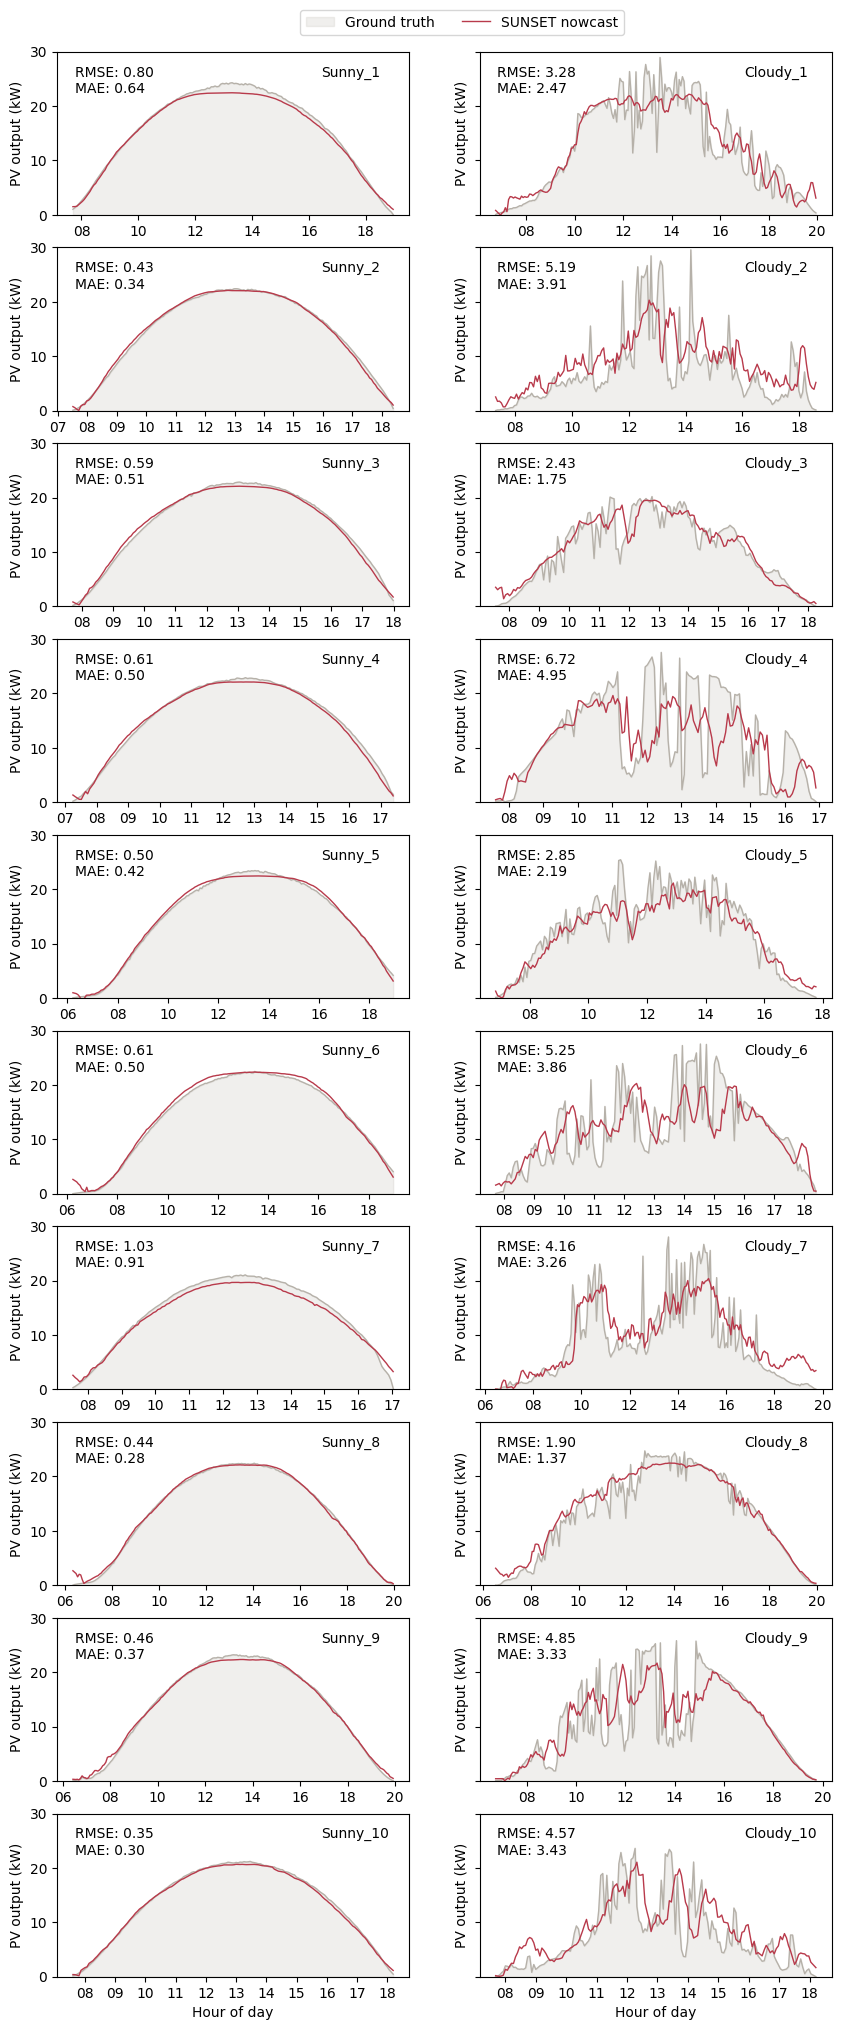

In [ ]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

red = '#B83A4B'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-preds_list_arr[date_mask]))))
    mae = np.mean(np.abs((pv_pred_test[date_mask]-preds_list_arr[date_mask])))

    ax.plot(hours_xaxis, pv_pred_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_pred_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, preds_list_arr[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=red,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-preds_list_arr[date_mask]))))
    mae = np.mean(np.abs((pv_pred_test[date_mask]-preds_list_arr[date_mask])))

    ax.plot(hours_xaxis, pv_pred_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_pred_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, preds_list_arr[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=red,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)


axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)
plt.show()

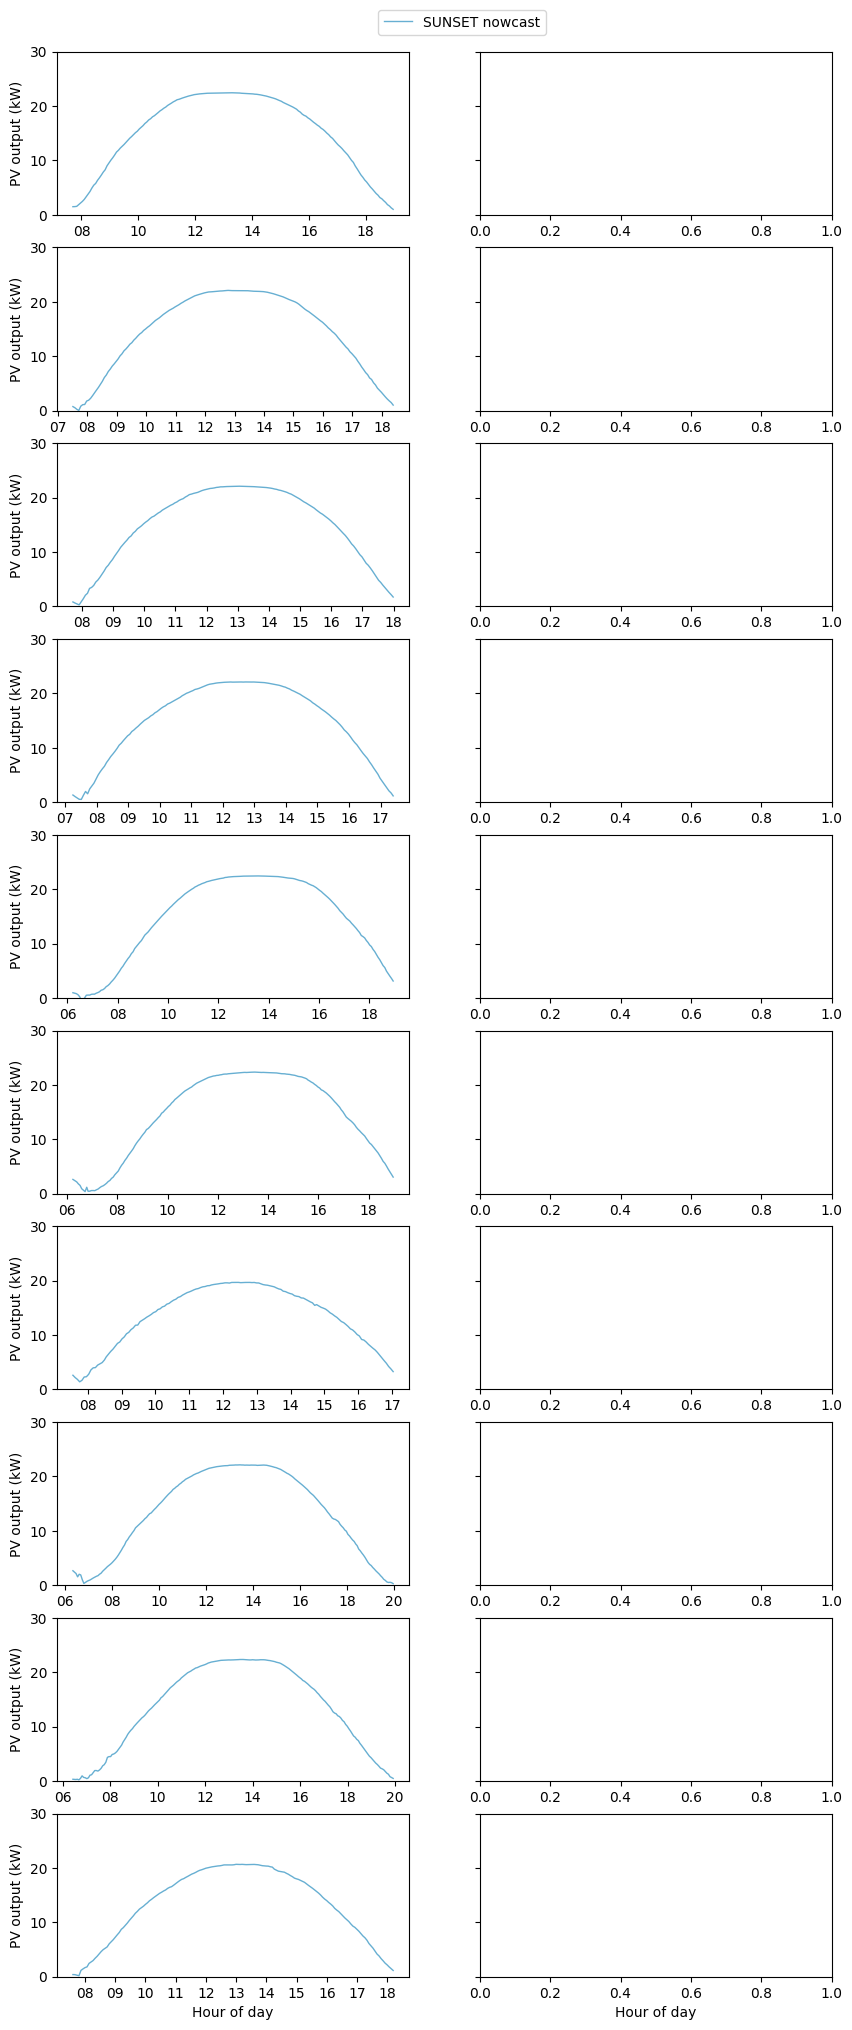

In [ ]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_pred_test[date_mask]-preds_list_arr[date_mask]))))
    mae = np.mean(np.abs((pv_pred_test[date_mask]-preds_list_arr[date_mask])))

    # ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    # ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, preds_list_arr[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    # ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    # ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)
plt.show()

plt.show()

In [ ]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)